Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/30
--------------------------------------------------
Train Loss: 0.1901 | Train Kappa: 0.9035
Val Loss: 0.0408 | Val Kappa: 0.9814 | Val Accuracy: 98.78%
Best model saved!

Epoch 2/30
--------------------------------------------------
Train Loss: 0.0239 | Train Kappa: 0.9951
Val Loss: 0.0154 | Val Kappa: 0.9925 | Val Accuracy: 99.51%
Best model saved!

Epoch 3/30
--------------------------------------------------
Train Loss: 0.0100 | Train Kappa: 0.9988
Val Loss: 0.0172 | Val Kappa: 0.9925 | Val Accuracy: 99.51%
Best model saved!

Epoch 4/30
--------------------------------------------------
Train Loss: 0.0182 | Train Kappa: 0.9951
Val Loss: 0.0110 | Val Kappa: 0.9925 | Val Accuracy: 99.51%

Epoch 5/30
--------------------------------------------------
Train Loss: 0.0064 | Train Kappa: 0.9976
Val Loss: 0.0061 | Val Kappa: 0.9963 | Val Accuracy: 99.76%
Best model saved!

Epoch 6/30
--------------------------------------------------
Train Loss: 0.0054 | Train Kappa: 0.9988
Val 

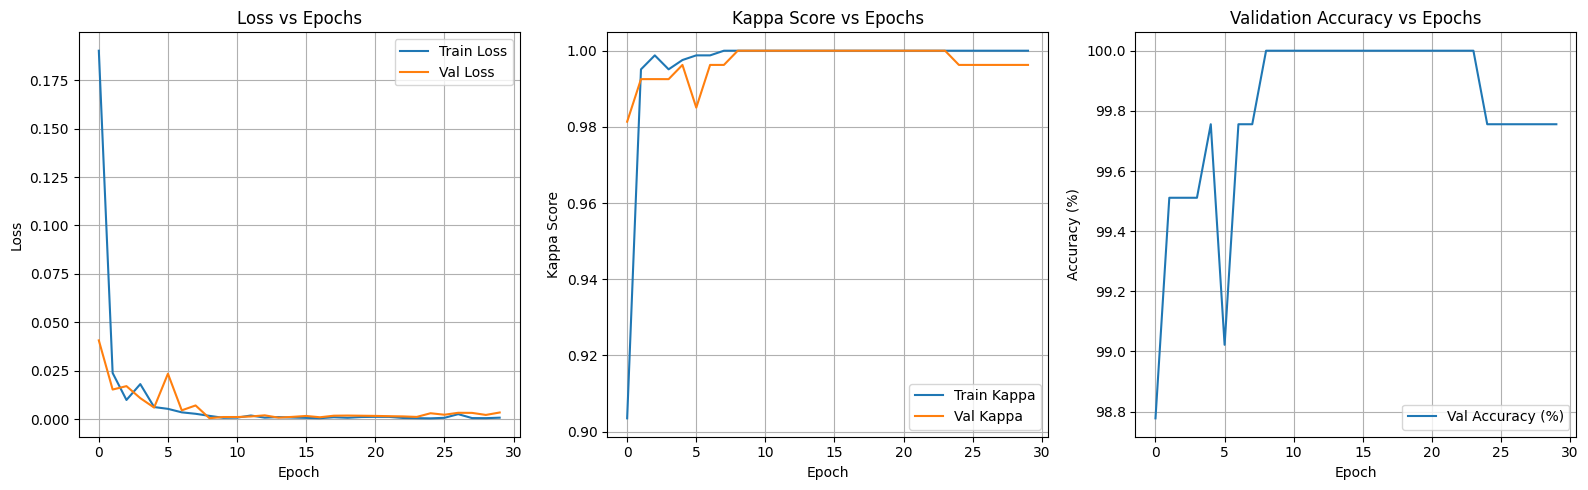


Confusion Matrix:
[[162   0   0]
 [  1  98   0]
 [  0   0 150]]
Cohen Kappa Score on Test Set: 0.9963
F1 Score (macro): 0.9973

Classification Report:
              precision    recall  f1-score   support

      Cancer       0.99      1.00      1.00       162
      Normal       1.00      0.99      0.99        99
     Unknown       1.00      1.00      1.00       150

    accuracy                           1.00       411
   macro avg       1.00      1.00      1.00       411
weighted avg       1.00      1.00      1.00       411



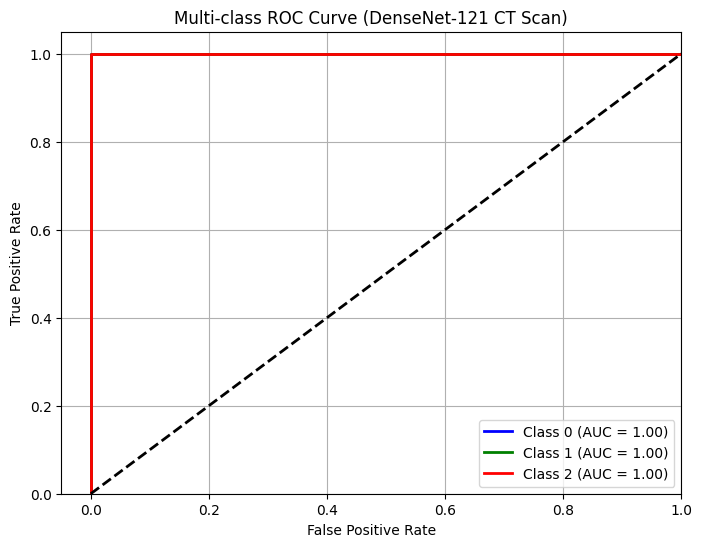

In [2]:
# ============================ IMPORTS ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

# ============================ CONFIG ============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

DATA_DIR = '/kaggle/input/project/ctscan-dataset-lung'  # <-- Update your path here

NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4

# ============================ TRANSFORMS ============================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================ DATASETS ============================
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)

# 60-20-20 split
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Update val and test datasets to use test_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# WeightedRandomSampler
targets = [label for _, label in train_dataset]
class_sample_count = np.array([targets.count(t) for t in np.unique(targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in targets])

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ============================ MODEL ============================
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# ============================ TRAINING ============================
best_val_kappa = -1
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []
train_kappas = []
val_kappas = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Training phase
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_loss = running_loss / len(train_loader)
    train_kappa = cohen_kappa_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_kappas.append(train_kappa)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_kappa = cohen_kappa_score(val_labels, val_preds)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_kappas.append(val_kappa)
    val_accuracies.append(val_accuracy)
    
    print(f"Train Loss: {train_loss:.4f} | Train Kappa: {train_kappa:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Kappa: {val_kappa:.4f} | Val Accuracy: {val_accuracy*100:.2f}%")

    # Save best model
    if val_kappa > best_val_kappa:
        best_val_kappa = val_kappa
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_ctscan_densenet_model.pth')
        print("Best model saved!")

    scheduler.step()

# Load best model
model.load_state_dict(best_model_wts)

# ============================ TRAINING CURVES ============================
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_kappas, label='Train Kappa')
plt.plot(val_kappas, label='Val Kappa')
plt.title('Kappa Score vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot([v*100 for v in val_accuracies], label='Val Accuracy (%)')
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# ============================ TESTING ============================
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

# Kappa Score
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen Kappa Score on Test Set: {kappa:.4f}")

# F1 Score and Classification Report
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

report = classification_report(all_labels, all_preds, target_names=['Cancer', 'Normal', 'Unknown'])
print("\nClassification Report:")
print(report)

# ============================ ROC CURVE ============================
# Get probabilities
probs = []
targets_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probs.append(outputs.softmax(dim=1).cpu().numpy())
        targets_list.append(targets.numpy())

probs = np.vstack(probs)
targets_list = np.hstack(targets_list)

# Binarize labels
targets_bin = label_binarize(targets_list, classes=[0, 1, 2])

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (DenseNet-121 CT Scan)')
plt.legend(loc="lower right")
plt.grid()
plt.show()
